# Sampling from an Ising Model using DMALAX

## 1. Setup

In [ ]:
!pip install jax
!pip install tensorflow-probability
!pip install igraph
!pip install git+https://github.com/Habush/DMALAX.git

In [2]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import dmalax
import igraph as ig
import itertools
from tensorflow_probability.substrates import jax as tfp
import time
tfd = tfp.distributions

In [3]:
rng_key = jax.random.PRNGKey(0)

## 2. Define a 4x4 Lattice Model

In [4]:
dim = 4
lattice_dim = 2
g = ig.Graph.Lattice(dim=[dim, dim])
J = np.asarray(g.get_adjacency().data)
p = dim ** 2
eta = 0.1 # connectivity strength
mu = 0.2 # bias
J.shape

(16, 16)

In [5]:
def get_gt_mean(J, mu):
  dim = J.shape[1]**2
  ar = jnp.array([-1., 1.])[None]
  ar_dup = jnp.repeat(ar, p, axis=0)
  arg = [ar_dup[i] for i in range(ar_dup.shape[0])]
  lst = jnp.array(list(itertools.product([-1.0, 1.0], repeat=dim)))
  print(lst.shape)
  f = lambda x: jnp.exp(jnp.sum((x @ J * x), axis=-1) + jnp.sum(mu*x, axis=-1))
  flst = jax.jit(f)(lst)
  plst = flst/jnp.sum(flst)
  gt_mean = jnp.sum(plst.reshape(-1, lst.shape[1]), axis=0)
  return gt_mean


def get_log_rmse(x, gt_mean):
  x = 2. * x - 1
  return jnp.log(jnp.sqrt(jnp.mean((x - gt_mean)**2)))

  return states 

def get_ess(chain, burn_in):
    c = chain
    l = c.shape[0]
    bi = int(burn_in * l)
    c = c[bi:]
    cv = tfp.mcmc.effective_sample_size(c)
    cv = cv.at[jnp.isnan(cv)*1].set(1.)
    return cv

In [6]:
# gt_mean = get_gt_mean(J, mu)
gt_mean = jnp.array([0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800,
        0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800]) # use pre-calculated mean as calculating it takes a lot of resources.
                                                                 # Uncomment the above line to verify

## 3. Define the log probability function for the Ising Model

In [7]:
def logprob_fn(theta, J, eta, mu):
  x = (2 * theta) - 1
  xg = x @ J
  xgx = jnp.sum((xg * x), axis=-1)
  return eta*xgx + mu*jnp.sum(x)

logprob = lambda x: logprob_fn(x, J, eta, mu)
grad_fn = jax.grad(logprob)

## 4. Initialized the kernel and define an initial position

In [8]:
step_size = 0.2
bin_dist = tfd.Bernoulli(probs=[0.5]*p)
init_pos = bin_dist.sample(seed=rng_key) * 1.
init_state = dmalax.dmala.init(init_pos, logprob)
dmala = dmalax.dmala(logprob, step_size)
dmala_kernel = jax.jit(dmala.step)
init_state

MALAState(position=DeviceArray([0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
             0.], dtype=float32, weak_type=True), logprob=DeviceArray(0.8, dtype=float32), logprob_grad=DeviceArray([-0.40000004,  0.4       , -0.40000004, -1.2       ,
              0.4       , -0.40000004, -0.4       , -1.2       ,
              0.4       ,  1.2       ,  0.4       , -0.4       ,
              0.4       ,  1.2       , -0.4       ,  0.4       ],            dtype=float32, weak_type=True))

## 5. Run the inference and collect stats

In [9]:
print_every = 100
num_samples = 10000
chain = np.zeros((num_samples, p))
keys = jax.random.split(rng_key, num_samples)
viz_every = 1000
time_list = []
times = []
rmses = []
mean = np.zeros(p)
cur_time = 0.

cur_state = init_state

for i in range(num_samples):
  key = keys[i]
  st = time.time()
  cur_state, _ = dmala_kernel(key, cur_state)
  cur_time += time.time() - st

  x = cur_state.position
  chain[i] = x
  mean = mean + x
  if i % viz_every == 0:
    time_list.append(cur_time)
    rmse = get_log_rmse(mean / (i+1), gt_mean)
    rmses.append(rmse)

  if i % print_every == 0:
    times.append(cur_time)
    print("=", end="")

mean = mean / num_samples

In [10]:
ess = get_ess(chain, 0.1)
print("ess = {} +/- {}".format(ess.mean(), ess.std()))

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


ess = 576.8231201171875 +/- 171.40316772460938


Text(0, 0.5, 'ess')

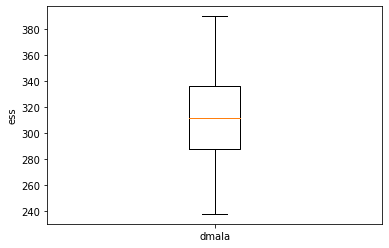

In [11]:
plt.boxplot([ess / times[-1] / (1. - 0.1)], labels=["dmala"], showfliers=False)
plt.ylabel("ess")

Text(0, 0.5, 'log RMSE')

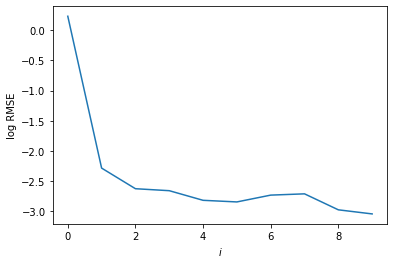

In [12]:
plt.plot(rmses)
plt.xlabel("$i$")
plt.ylabel("log RMSE")

## Inference loop

In the above cells, we've implemented the inference loop using a vanilla Python `for`- loop to collect stats during the run. However, for typical usage, you'd want to implement an inference loop using `jax` for speed. Check the code below

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
  @jax.jit
  def one_step(state, rng_key):
    state, _ = kernel(rng_key, state)
    return state, state

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)

  return states


def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):
  
  def one_step(states, rng_key):
    keys = jax.random.split(rng_key, num_chains)
    states, _ = jax.vmap(kernel)(keys, states)
    return states, states

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)